In [23]:
import sys
import scipy.sparse as sp
import numpy as np
from scipy.io import loadmat, savemat
import os

### Load data

In [24]:
# Hofree's result --- 100 and 1000 permutations of bootstrap
hof_100_data = loadmat('100permutations/results_NBS_Hofree_100.mat')
hof_1000_data = loadmat('1000permutations/results_NBS_Hofree_1000.mat')

# StratiPy's result --- 100 and 1000 permutations of bootstrap
stp_100_data = loadmat('100permutations/hierarchical_clustering_Patients_weight=min_simp=True_alpha=0.7_tol=0.001_singletons=False_ngh=11_minMut=10_maxMut=200000_comp=3_permut=100_lambd=1_tolNMF=0.001_method=average.mat')
stp_1000_data = loadmat('1000permutations/hierarchical_clustering_Patients_weight=min_simp=True_alpha=0.7_tol=0.001_singletons=False_ngh=11_minMut=10_maxMut=200000_comp=3_permut=1000_lambd=1_tolNMF=0.001_method=average.mat')

# StratiPy's result with lambda = 1800
stp_100_data_lamb1800 = loadmat('100permutations/lamb1800/hierarchical_clustering_Patients_weight=min_simp=True_alpha=0.7_tol=0.001_singletons=False_ngh=11_minMut=10_maxMut=200000_comp=3_permut=100_lambd=1800_tolNMF=0.001_method=average.mat')

data check

In [25]:
hof_100_data

{'NBS_cc_cluster': array([[ (array([[ (array([[array([], shape=(1, 0), dtype=float64),
         array([], shape=(1, 0), dtype=float64),
         array([[79, 58,  2, ..., 60, 60, 60],
        [58, 71,  3, ..., 57, 52, 56],
        [ 2,  3, 79, ...,  4,  2,  2],
        ..., 
        [60, 57,  4, ..., 83, 62, 63],
        [60, 52,  2, ..., 62, 78, 64],
        [60, 56,  2, ..., 63, 64, 81]], dtype=uint8)]], dtype=object), array([[array([], shape=(1, 0), dtype=float64),
         array([], shape=(1, 0), dtype=float64),
         array([[ 1.        ,  1.        ,  0.03125   , ...,  0.95238095,
          0.98360656,  0.95238095],
        [ 1.        ,  1.        ,  0.05454545, ...,  0.93442623,
          0.98113208,  0.94915254],
        [ 0.03125   ,  0.05454545,  1.        , ...,  0.06060606,
          0.03448276,  0.03125   ],
        ..., 
        [ 0.95238095,  0.93442623,  0.06060606, ...,  1.        ,
          0.92537313,  0.92647059],
        [ 0.98360656,  0.98113208,  0.03448276, .

In [26]:
stp_100_data

{'Z_linkage_matrix': array([[  3.40000000e+01,   1.23000000e+02,   7.50524644e-02,
           2.00000000e+00],
        [  2.60000000e+01,   2.38000000e+02,   9.11957502e-02,
           2.00000000e+00],
        [  9.00000000e+00,   2.43000000e+02,   9.57799927e-02,
           2.00000000e+00],
        [  1.80000000e+01,   2.48000000e+02,   1.04598197e-01,
           3.00000000e+00],
        [  2.02000000e+02,   2.42000000e+02,   1.06932369e-01,
           2.00000000e+00],
        [  1.00000000e+00,   2.49000000e+02,   1.12029978e-01,
           3.00000000e+00],
        [  7.80000000e+01,   9.00000000e+01,   1.14795344e-01,
           2.00000000e+00],
        [  2.51000000e+02,   2.53000000e+02,   1.15279897e-01,
           6.00000000e+00],
        [  1.24000000e+02,   1.44000000e+02,   1.16183702e-01,
           2.00000000e+00],
        [  3.50000000e+01,   7.90000000e+01,   1.19577822e-01,
           2.00000000e+00],
        [  3.20000000e+01,   2.30000000e+02,   1.23182980e-01,
       

In [27]:
for key, value in hof_100_data.items() :
    print (key)

NBS_cc_label
NBS_cc_cluster
__globals__
__header__
__version__
propnmf_options


In [28]:
hof_1000_data['propnmf_options']

array([[ (array(['netnmf'], 
      dtype='<U6'), array([[3]], dtype=uint8), array([[10]], dtype=uint8), array([[ 0.7]]), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array([[1000]], dtype=uint16), array([[ 0.8]]), array([[ 0.8]]))]], 
      dtype=[('nmf_type', 'O'), ('K', 'O'), ('min_mutations', 'O'), ('proV', 'O'), ('dis', 'O'), ('pb', 'O'), ('normalize_rows', 'O'), ('isNetwork', 'O'), ('nsample', 'O'), ('smp_ind', 'O'), ('smp_feat', 'O')])

In [29]:
hof_100_data['NBS_cc_label'].shape

(248, 1)

In [30]:
stp_100_data['flat_cluster_number'].shape

(1, 248)

In [31]:
hof_1000_data['NBS_cc_label'].shape

(248, 1)

### Get number of subgroups for each patient 
there are 3 subroups

In [32]:
# Hofree
hof_100_3cluster = hof_100_data['NBS_cc_label'].squeeze().tolist()
hof_1000_3cluster = hof_1000_data['NBS_cc_label'].squeeze().tolist()

# StratiPy
stp_100_3cluster = list(stp_100_data['flat_cluster_number'][0])
stp_1000_3cluster = list(stp_1000_data['flat_cluster_number'][0])
stp_100_lamb1800_3cluster = list(stp_100_data_lamb1800['flat_cluster_number'][0])

In [33]:
def replace_list_element(l, before, after):
    for i,e in enumerate(l):
        if e==before:
            l[i]=after
    return l

In [34]:
# clust(Hofree) 3(1) <-> clust(Stratipy) 1(3)
stp_100_3cluster_1 = replace_list_element(stp_100_3cluster, 3, 0) # 3 -> 0
stp_100_3cluster_2 = replace_list_element(stp_100_3cluster_1, 1, 3) # 1 -> 3
stp_100_3cluster_3 = replace_list_element(stp_100_3cluster_2, 0, 1) # 0 -> 1

### Confusion matrices

In [35]:
from sklearn.metrics import confusion_matrix

#### 100 vs 1000 permutations of Bootstrap

In [36]:
# Hofree 100 & 1000
confusion_matrix(hof_100_3cluster, hof_1000_3cluster)

array([[  0,  61,   0],
       [103,   1,   0],
       [  1,   0,  82]])

In [37]:
# 100 permutations
confusion_matrix(stp_100_3cluster, stp_1000_3cluster)

array([[  0,  59,   0],
       [  0,   0,  29],
       [159,   0,   1]])

=> There are no significant differences between 100 and 1000 permutations of Bootstrap.

#### Hofree vs StratiPy

In [38]:
# 100 permutations
# StratiPy's lambd = 1
confusion_matrix(hof_100_3cluster, stp_100_3cluster)

array([[54,  0,  7],
       [ 5,  0, 99],
       [ 0, 29, 54]])

In [39]:
# 1000 permutations
# StratiPy's lambd = 1
confusion_matrix(hof_1000_3cluster, stp_1000_3cluster)

array([[100,   4,   0],
       [  7,  55,   0],
       [ 52,   0,  30]])

In [40]:
# 100 permutations
# StratiPy's lambd = 1800
confusion_matrix(hof_100_3cluster, stp_100_lamb1800_3cluster)

array([[57,  0,  4],
       [ 5, 90,  9],
       [ 2,  0, 81]])

### Plot

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

In [42]:
conf_arr = confusion_matrix(hof_100_3cluster, stp_100_3cluster)
conf_arr

array([[54,  0,  7],
       [ 5,  0, 99],
       [ 0, 29, 54]])

In [43]:
conf_arr = np.array([[54,  7,  0],
                  [ 5,  99, 0],
                  [ 0, 54, 29]])

conf_arr = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
conf_arr = np.around(conf_arr, decimals=2)
conf_arr

array([[ 0.89,  0.11,  0.  ],
       [ 0.05,  0.95,  0.  ],
       [ 0.  ,  0.65,  0.35]])

NameError: name 'colors' is not defined

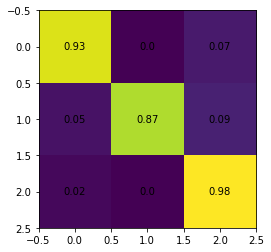

In [52]:
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.viridis, interpolation='nearest') #plt.cm.viridis

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

levels = np.linspace(0, 1, 11, endpoint=True)
cb = fig.colorbar(res, ticks=levels, norm=colors.NoNorm)
cb.set_clim(vmin=0, vmax=0.98)
alphabet = '123'
plt.xticks(range(width), alphabet[:width])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.yticks(range(height), alphabet[:height])

plt.xlabel('Subgroups')
plt.title("Reported tuning parameter value \n\n", fontsize=14)

# plt.savefig('confusion_matrix_lambd1.pdf', bbox_inches='tight')
# plt.savefig('confusion_matrix_lambd1.svg', bbox_inches='tight')

plt.show()

In [45]:
conf_arr = confusion_matrix(hof_100_3cluster, stp_100_lamb1800_3cluster)
conf_arr = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
conf_arr = np.around(conf_arr, decimals=2)
conf_arr

array([[ 0.93,  0.  ,  0.07],
       [ 0.05,  0.87,  0.09],
       [ 0.02,  0.  ,  0.98]])

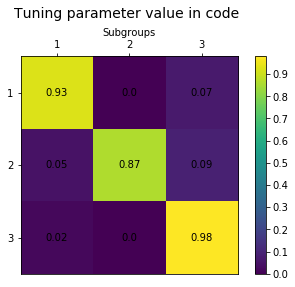

In [46]:
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.viridis, interpolation='nearest') #plt.cm.viridis

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res, ticks=levels)
# cb.set_clim(vmin=0, vmax=0.98)

alphabet = '123'
plt.xticks(range(width), alphabet[:width])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.yticks(range(height), alphabet[:height])

plt.xlabel('Subgroups')
plt.title("Tuning parameter value in code \n\n", fontsize=14)

# plt.savefig('confusion_matrix_lambd1800.pdf', bbox_inches='tight')
# plt.savefig('confusion_matrix_lambd1800.svg', bbox_inches='tight')

plt.show()